(GLM-rolling-regression)=
# Rolling Regression

:::{post} Jan 28, 2023
:tags: generalized linear model, regression 
:category: intermediate
:author: Thomas Wiecki
:::

* [Pairs trading](https://en.wikipedia.org/wiki/Pairs_trade?oldformat=true) is a famous technique in algorithmic trading that plays two stocks against each other.
* For this to work, stocks must be correlated (cointegrated).
* One common example is the price of gold (GLD) and the price of gold mining operations (GFI).

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from matplotlib import MatplotlibDeprecationWarning

warnings.filterwarnings(action="ignore", category=MatplotlibDeprecationWarning)

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Lets load the prices of GFI and GLD.

In [3]:
# from pandas_datareader import data
# prices = data.GoogleDailyReader(symbols=['GLD', 'GFI'], end='2014-8-1').read().loc['Open', :, :]
try:
    prices = pd.read_csv(os.path.join("..", "data", "stock_prices.csv")).dropna()
except FileNotFoundError:
    prices = pd.read_csv(pm.get_data("stock_prices.csv")).dropna()

prices["Date"] = pd.DatetimeIndex(prices["Date"])
prices = prices.set_index("Date")
prices_zscored = (prices - prices.mean()) / prices.std()
prices.head()

,GFI,GLD
Date,,
2010-01-04,13.55,109.82
2010-01-05,13.51,109.88
2010-01-06,13.70,110.71
2010-01-07,13.63,111.07
2010-01-08,13.72,111.52


Plotting the prices over time suggests a strong correlation. However, the correlation seems to change over time.

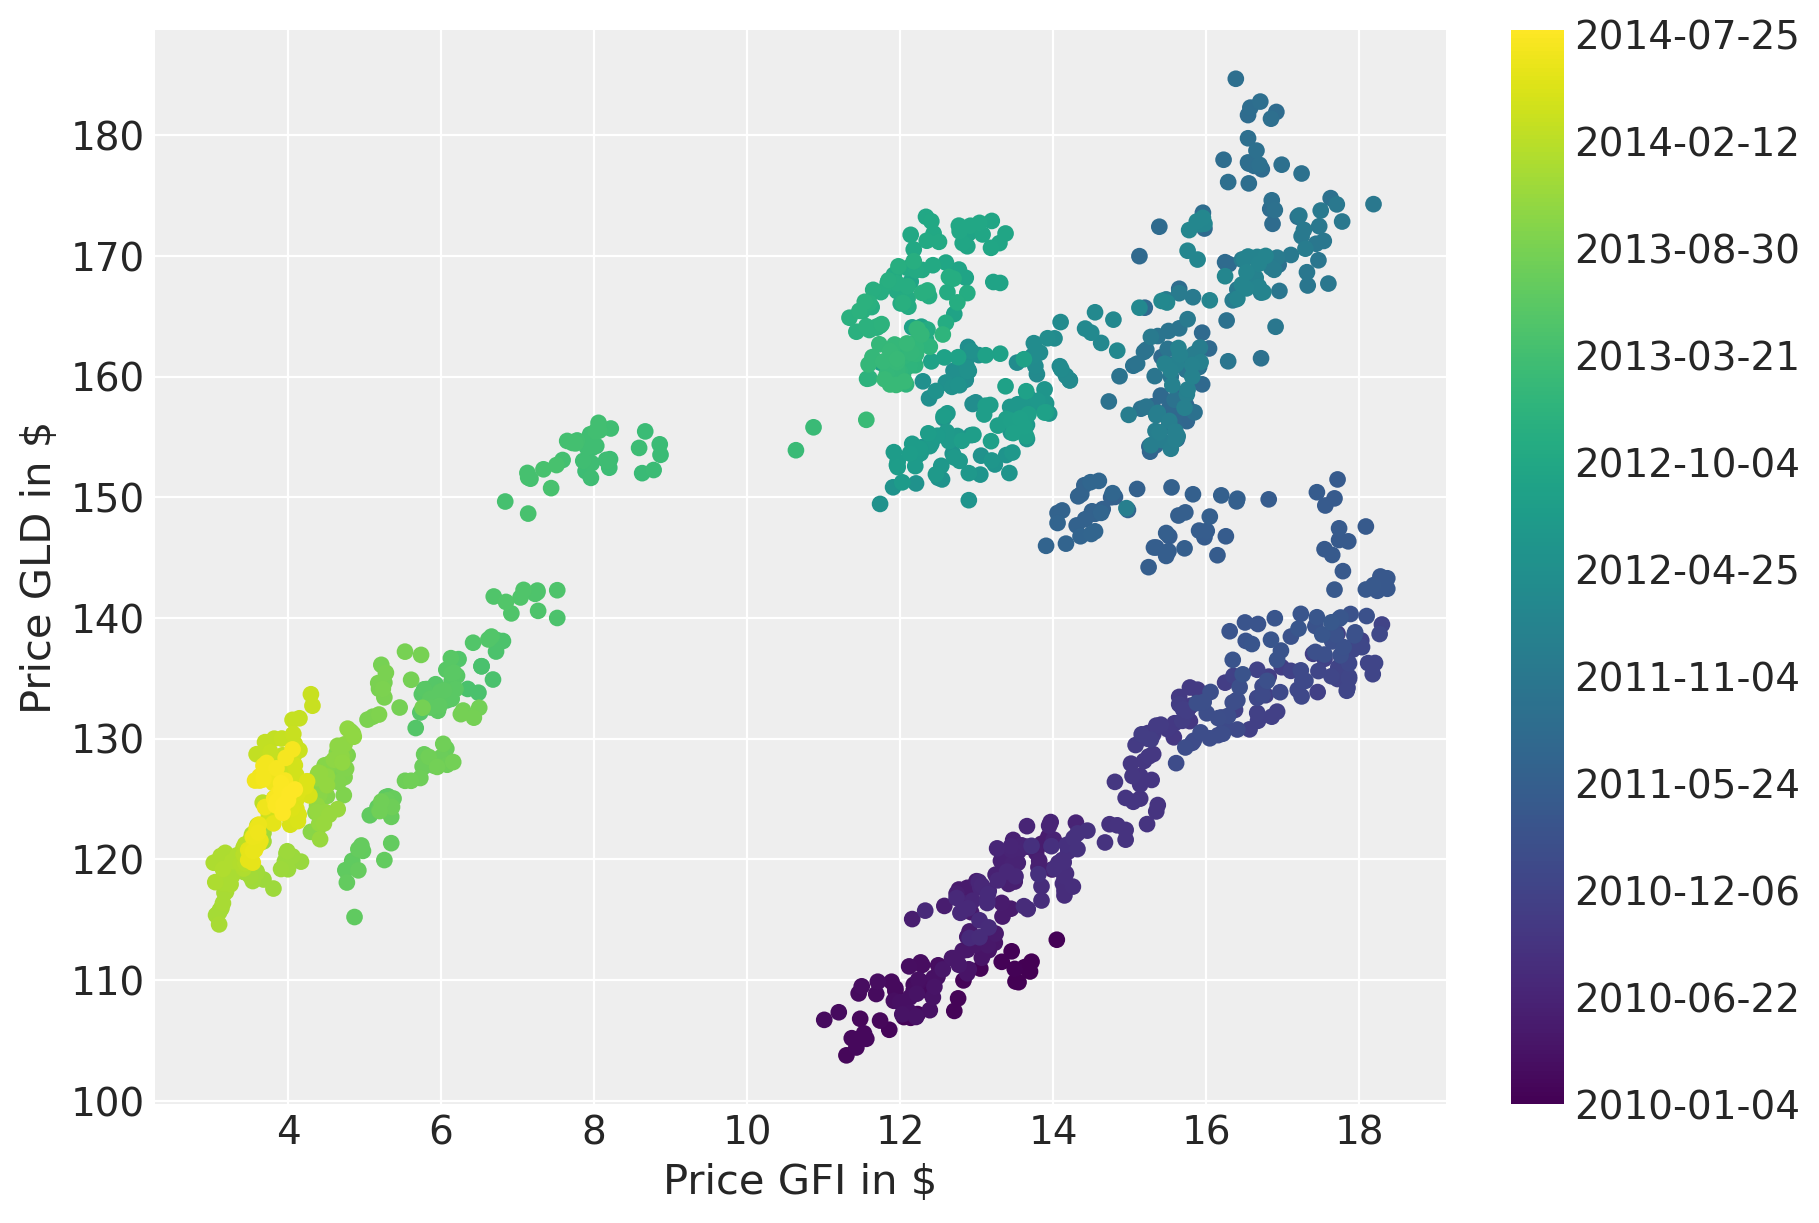

In [4]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, xlabel=r"Price GFI in \$", ylabel=r"Price GLD in \$")
colors = np.linspace(0, 1, len(prices))
mymap = plt.get_cmap("viridis")
sc = ax.scatter(prices.GFI, prices.GLD, c=colors, cmap=mymap, lw=0)
ticks = colors[:: len(prices) // 10]
ticklabels = [str(p.date()) for p in prices[:: len(prices) // 10].index]
cb = plt.colorbar(sc, ticks=ticks)
cb.ax.set_yticklabels(ticklabels);

A naive approach would be to estimate a linear model and ignore the time domain.

In [5]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    sigma = pm.HalfCauchy("sigma", beta=10)
    alpha = pm.Normal("alpha", mu=0, sigma=20)
    beta = pm.Normal("beta", mu=0, sigma=20)

    mu = pm.Deterministic("mu", alpha + beta * prices_zscored.GFI.to_numpy())

    # Define likelihood
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=prices_zscored.GLD.to_numpy())

    # Inference
    trace_reg = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha, beta]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 15 seconds.


The posterior predictive plot shows how bad the fit is.

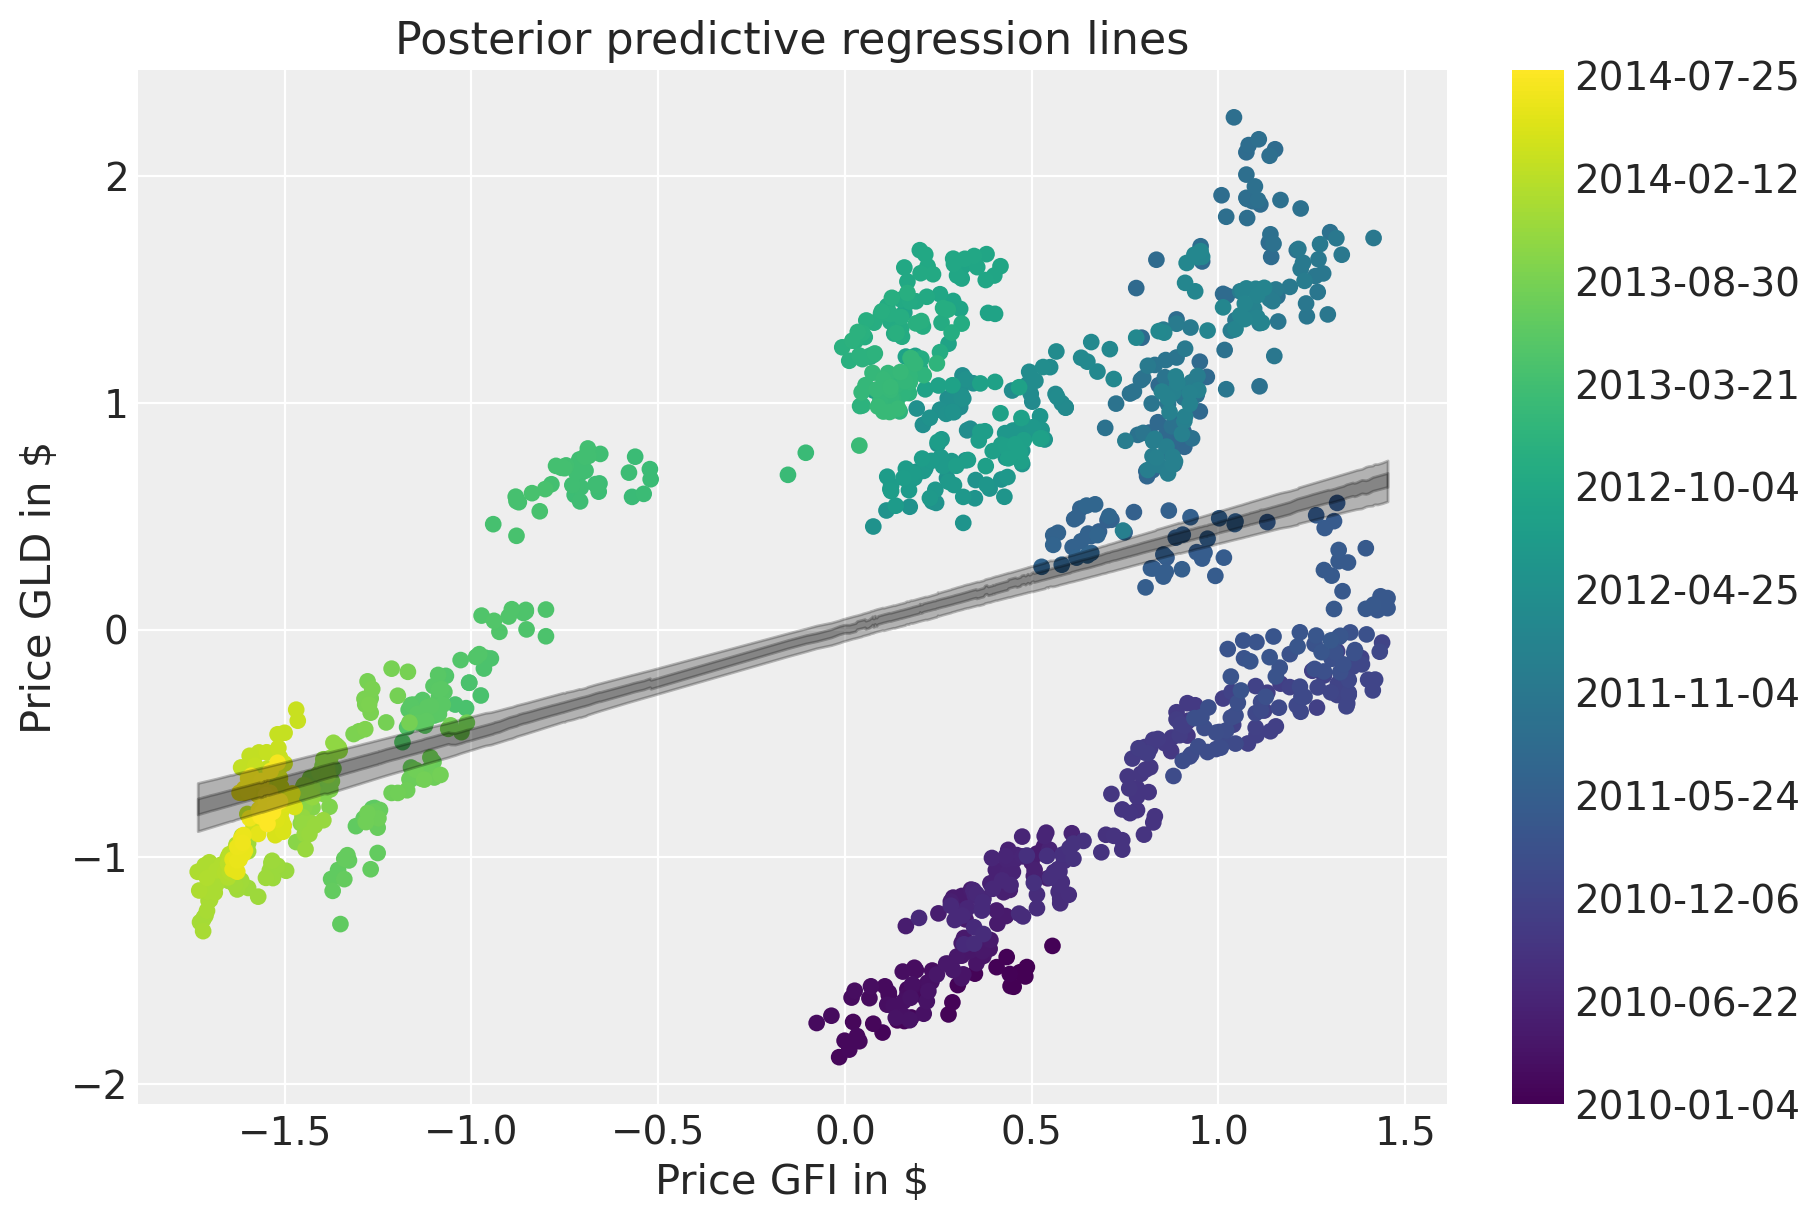

In [6]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(
    111,
    xlabel=r"Price GFI in \$",
    ylabel=r"Price GLD in \$",
    title="Posterior predictive regression lines",
)
sc = ax.scatter(prices_zscored.GFI, prices_zscored.GLD, c=colors, cmap=mymap, lw=0)

xi = xr.DataArray(prices_zscored.GFI.values)
az.plot_hdi(
    xi,
    trace_reg.posterior.mu,
    color="k",
    hdi_prob=0.95,
    ax=ax,
    fill_kwargs={"alpha": 0.25},
    smooth=False,
)
az.plot_hdi(
    xi,
    trace_reg.posterior.mu,
    color="k",
    hdi_prob=0.5,
    ax=ax,
    fill_kwargs={"alpha": 0.25},
    smooth=False,
)

cb = plt.colorbar(sc, ticks=ticks)
cb.ax.set_yticklabels(ticklabels);

## Rolling regression

Next, we will build an improved model that will allow for changes in the regression coefficients over time. Specifically, we will assume that intercept and slope follow a random-walk through time. That idea is similar to the {doc}`case_studies/stochastic_volatility`.

$$ \alpha_t \sim \mathcal{N}(\alpha_{t-1}, \sigma_\alpha^2) $$
$$ \beta_t \sim \mathcal{N}(\beta_{t-1}, \sigma_\beta^2) $$

First, lets define the hyper-priors for $\sigma_\alpha^2$ and $\sigma_\beta^2$. This parameter can be interpreted as the volatility in the regression coefficients.

In [7]:
with pm.Model(coords={"time": prices.index.values}) as model_randomwalk:
    # std of random walk
    sigma_alpha = pm.Exponential("sigma_alpha", 50.0)
    sigma_beta = pm.Exponential("sigma_beta", 50.0)

    alpha = pm.GaussianRandomWalk(
        "alpha", sigma=sigma_alpha, init_dist=pm.Normal.dist(0, 10), dims="time"
    )
    beta = pm.GaussianRandomWalk(
        "beta", sigma=sigma_beta, init_dist=pm.Normal.dist(0, 10), dims="time"
    )

Perform the regression given coefficients and data and link to the data via the likelihood.

In [8]:
with model_randomwalk:
    # Define regression
    regression = alpha + beta * prices_zscored.GFI.values

    # Assume prices are Normally distributed, the mean comes from the regression.
    sd = pm.HalfNormal("sd", sigma=0.1)
    likelihood = pm.Normal("y", mu=regression, sigma=sd, observed=prices_zscored.GLD.to_numpy())

Inference. Despite this being quite a complex model, NUTS handles it wells.

In [9]:
with model_randomwalk:
    trace_rw = pm.sample(tune=2000, target_accept=0.9)

/Users/reshamashaikh/miniforge3/envs/pymc-dev/lib/python3.11/site-packages/pymc/logprob/joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/Users/reshamashaikh/miniforge3/envs/pymc-dev/lib/python3.11/site-packages/pymc/logprob/joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/Users/reshamashaikh/miniforge3/envs/pymc-dev/lib/python3.11/site-packages/pymc/logprob/joint_logprob.py:167: UserWarning: Found a random variable that was neither among the observations nor the conditioned variables: [normal_rv{0, (0, 0), floatX, False}.0, normal_rv{0, (0, 0), floatX, False}.out]
  warnings.warn(
/Users/reshamashaikh/miniforge3/envs/pymc-dev/lib/py

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 1914 seconds.


Increasing the tree-depth does indeed help but it makes sampling very slow. The results look identical with this run, however.

## Analysis of results

As can be seen below, $\alpha$, the intercept, changes over time.

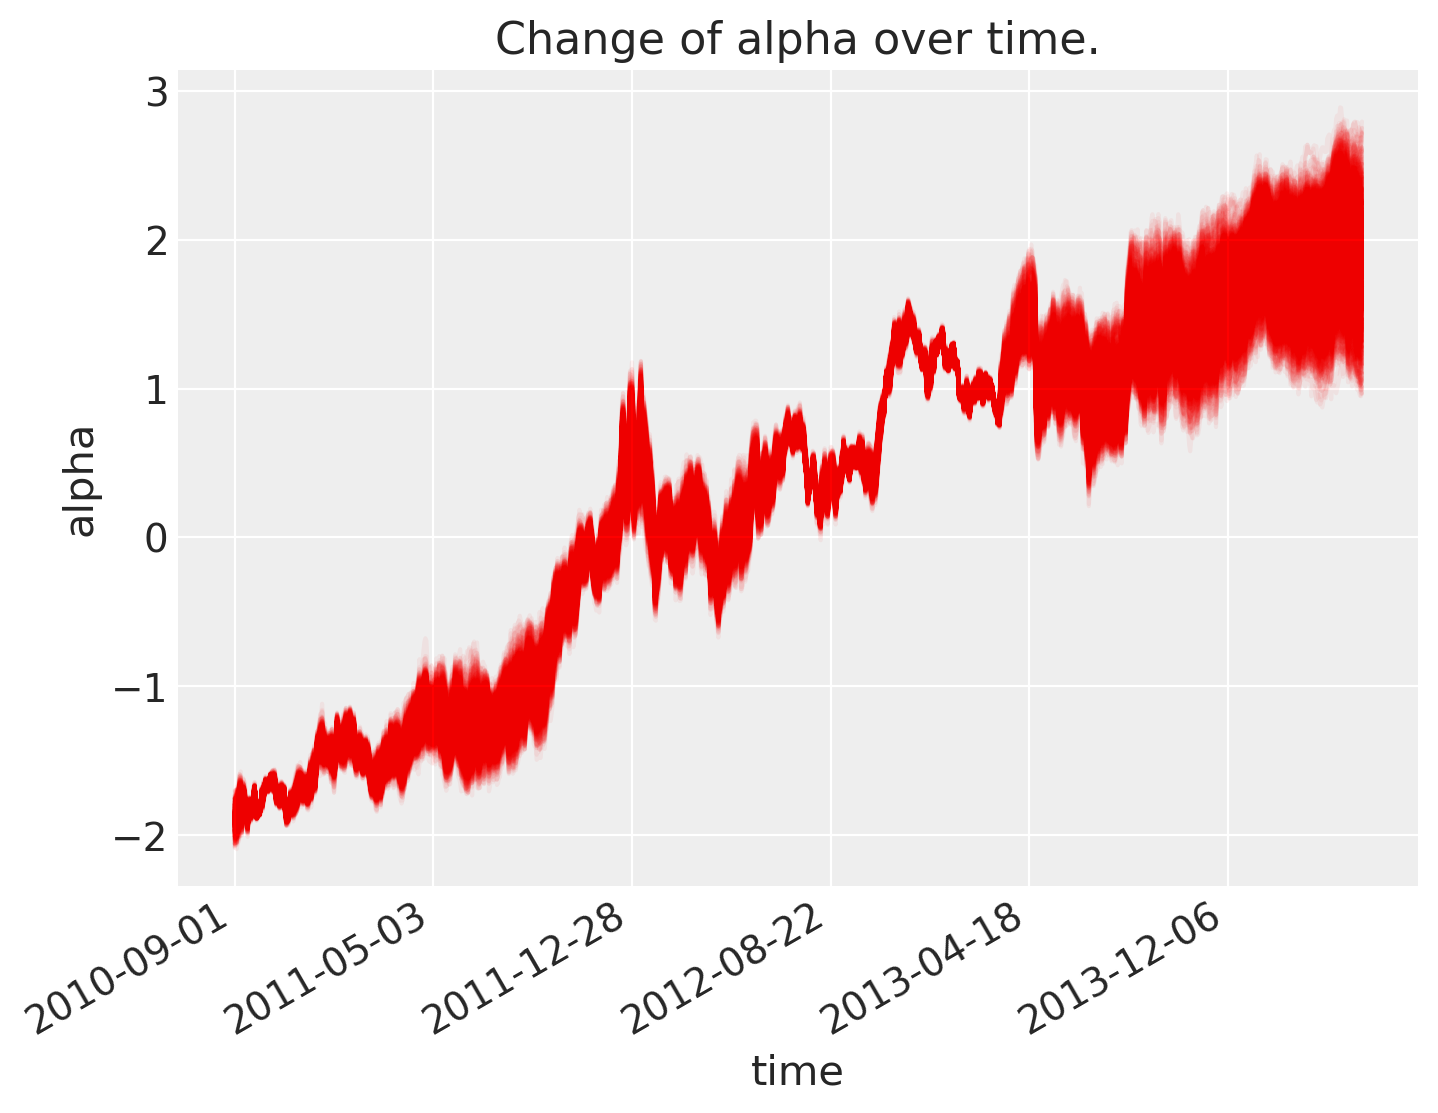

In [10]:
fig = plt.figure(figsize=(8, 6), constrained_layout=False)
ax = plt.subplot(111, xlabel="time", ylabel="alpha", title="Change of alpha over time.")
ax.plot(trace_rw.posterior.stack(pooled_chain=("chain", "draw"))["alpha"], "r", alpha=0.05)

ticks_changes = mticker.FixedLocator(ax.get_xticks().tolist())
ticklabels_changes = [str(p.date()) for p in prices[:: len(prices) // 7].index]
ax.xaxis.set_major_locator(ticks_changes)
ax.set_xticklabels(ticklabels_changes)

fig.autofmt_xdate()

As does the slope.

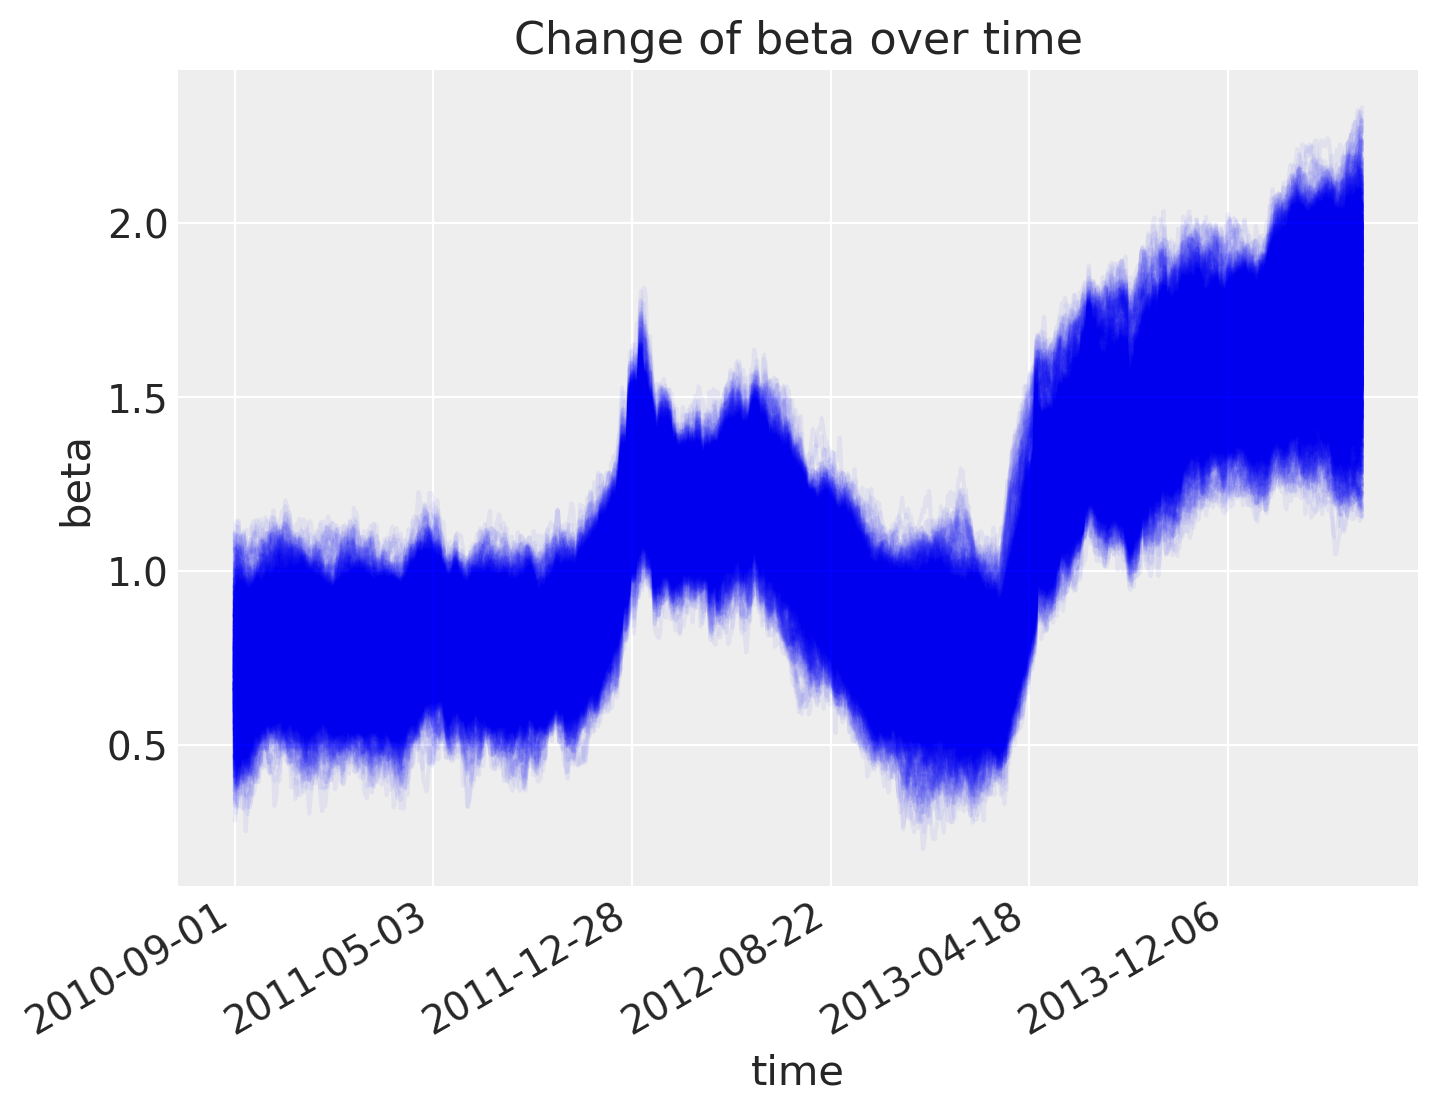

In [11]:
fig = plt.figure(figsize=(8, 6), constrained_layout=False)
ax = fig.add_subplot(111, xlabel="time", ylabel="beta", title="Change of beta over time")
ax.plot(trace_rw.posterior.stack(pooled_chain=("chain", "draw"))["beta"], "b", alpha=0.05)

ax.xaxis.set_major_locator(ticks_changes)
ax.set_xticklabels(ticklabels_changes)

fig.autofmt_xdate()

The posterior predictive plot shows that we capture the change in regression over time much better. Note that we should have used returns instead of prices. The model would still work the same, but the visualisations would not be quite as clear.

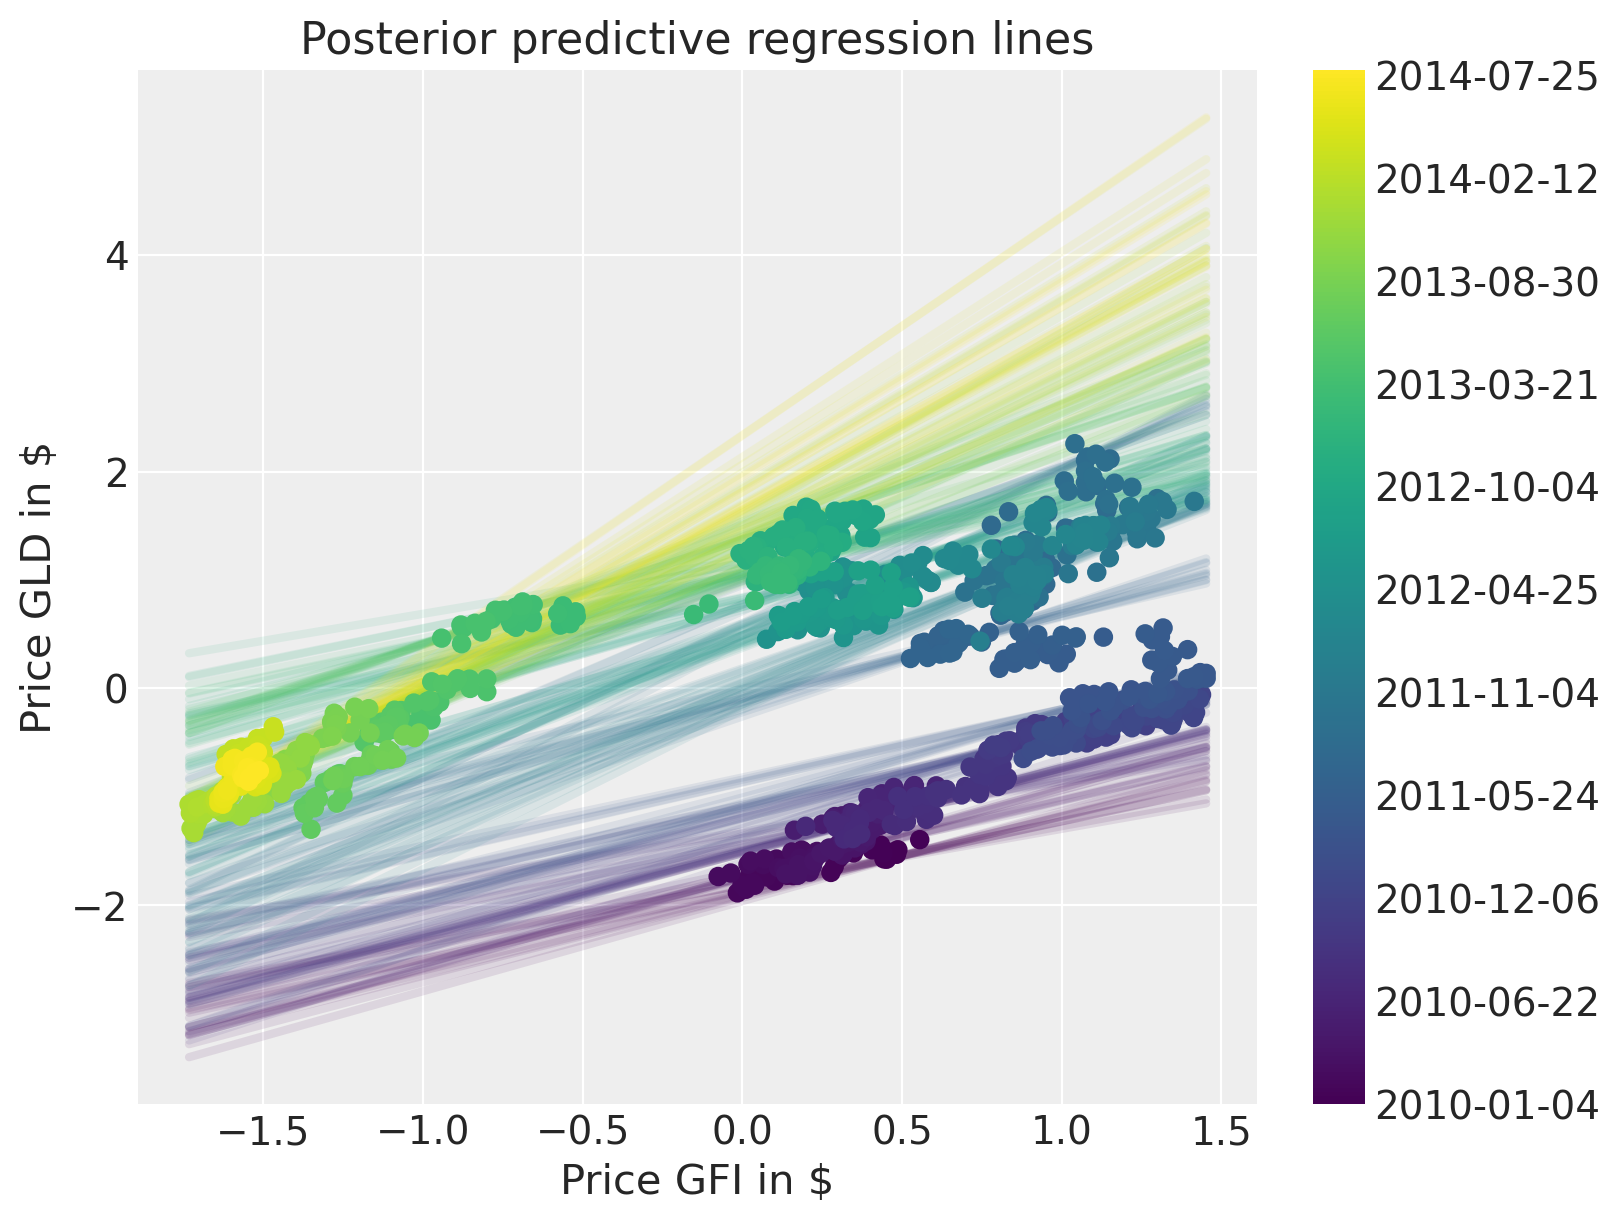

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(
    111,
    xlabel=r"Price GFI in \$",
    ylabel=r"Price GLD in \$",
    title="Posterior predictive regression lines",
)

colors = np.linspace(0, 1, len(prices))
colors_sc = np.linspace(0, 1, len(prices.index.values[::50]))

xi = xr.DataArray(np.linspace(prices_zscored.GFI.min(), prices_zscored.GFI.max(), 50))

for i, time in enumerate(prices.index.values[::50]):
    sel_trace = trace_rw.posterior.sel(time=time)
    regression_line = (
        (sel_trace["alpha"] + sel_trace["beta"] * xi)
        .stack(pooled_chain=("chain", "draw"))
        .isel(pooled_chain=slice(None, None, 200))
    )
    ax.plot(xi, regression_line, color=mymap(colors_sc[i]), alpha=0.1, zorder=10, linewidth=3)

sc = ax.scatter(
    prices_zscored.GFI, prices_zscored.GLD, label="data", cmap=mymap, c=colors, zorder=11
)

cb = plt.colorbar(sc, ticks=ticks)
cb.ax.set_yticklabels(ticklabels);

## Authors

- Created by [Thomas Wiecki](https://github.com/twiecki/)
- Updated by [Benjamin T. Vincent](https://github.com/drbenvincent) June 2022
- Run PyMC v5 by Reshama Shaikh, January 2023

## Watermark

In [13]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Sat Jan 28 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.8.0

pytensor: 2.8.11
aeppl   : not installed
xarray  : 2022.12.0

xarray    : 2022.12.0
arviz     : 0.14.0
numpy     : 1.24.1
pymc      : 5.0.1
matplotlib: 3.6.2
pandas    : 1.5.2

Watermark: 2.3.1



:::{include} ../page_footer.md
:::